# Data Description

* The dataset contains transactions made by credit cards in September 2013 by European cardholders.
* This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
* It contains only numerical input variables which are the result of a PCA(Principal Component Analysis) transformation.
* Unfortunately, due to confidentiality issues, The company cannot provide the original features and more background information about the data. 
* Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
* Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
* The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
* Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


##### Source of Data: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# Import Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


# Import Data

In [2]:
data = pd.read_csv("data/creditcard.csv")

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# EDA

In [4]:
# get the shape of the data 
data.shape

(284807, 31)

Findings: Here we have 31 Features out of which `class` is the target feature. The dataset also contain 284807 records/Transactinos. 

In [5]:
# Get unique values of the target class
data.Class.unique()

array([0, 1], dtype=int64)

Findings: Here we have 2 class as the target. `0` indicates no fradulent activity and `1` represent fradulent activity.

In [6]:
# check the number of transaction for fradulent and non-fradulent activity
print("Transactions with Non_fradulent activity:",data[data.Class == 0].shape)
print("Transaction with Fradulent activity:", data[data.Class == 1].shape)

Transactions with Non_fradulent activity: (284315, 31)
Transaction with Fradulent activity: (492, 31)


C:\Users\HP\AppData\Local\Temp\ipykernel_18972\1099166886.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  class_count = pd.value_counts(data.Class, sort = True)


Text(0, 0.5, 'Frequency')

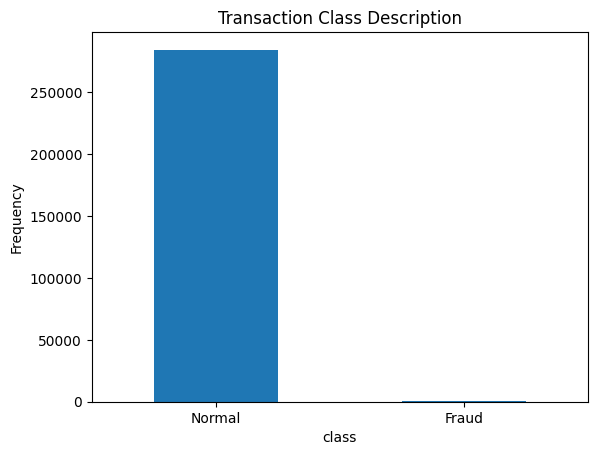

In [7]:
class_count = pd.value_counts(data.Class, sort = True)

class_count.plot(kind='bar', rot=0)

plt.title("Transaction Class Description")

plt.xticks(range(2), ["Normal", "Fraud"])

plt.xlabel('class')
plt.ylabel("Frequency")

Findings: For non-fraudela transaction we have `284315` records and for frodual transactino we have `492` records. This shows that the data is highly imbalanced.

In [8]:
# check for any null values 
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Findings: Since the data is already processed, There are no null values.

In [9]:
# get the description for Non-Fradulent activity 
data[data.Class == 0].describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,...,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.0
mean,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022,0.0
std,47484.015786,1.929814,1.636146,1.459429,1.399333,1.356952,1.329913,1.178812,1.161283,1.089372,...,0.716743,0.723668,0.621541,0.605776,0.520673,0.482241,0.399847,0.329570,250.105092,0.0
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.0
25%,54230.000000,-0.917544,-0.599473,-0.884541,-0.850077,-0.689398,-0.766847,-0.551442,-0.208633,-0.640412,...,-0.228509,-0.542403,-0.161702,-0.354425,-0.317145,-0.327074,-0.070852,-0.052950,5.650000,0.0
50%,84711.000000,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,...,-0.029821,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199,22.000000,0.0
75%,139333.000000,1.316218,0.800446,1.028372,0.737624,0.612181,0.399619,0.571019,0.326200,0.598230,...,0.185626,0.528407,0.147522,0.439869,0.350594,0.240671,0.090573,0.077962,77.050000,0.0
max,172792.000000,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,...,22.614889,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,0.0


In [10]:
# get the description for Fradulent activity 
data[data.Class == 1].describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


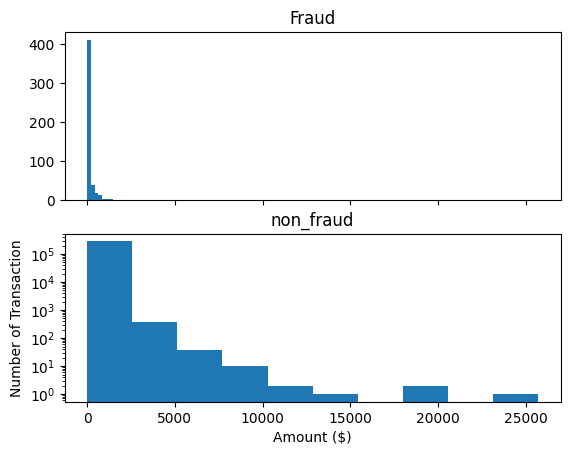

In [11]:
# Visualize amount per transaction done
fraud = data[data.Class == 1]
non_fraud = data[data.Class == 0]
bins = 50
f, (ax1, ax2) = plt.subplots(2, 1, sharex= True)
ax1.hist(fraud.Amount)
ax1.set_title("Fraud")

ax2.hist(non_fraud.Amount)
ax2.set_title("non_fraud")

plt.xlabel("Amount ($)")
plt.ylabel("Number of Transaction")

plt.yscale('log')

Findings: As we can see in above figure, Fradulent Transaction are mostly done in smaller amount. WHere as the non_fradulent tractions can be small and large amounts.

<Axes: >

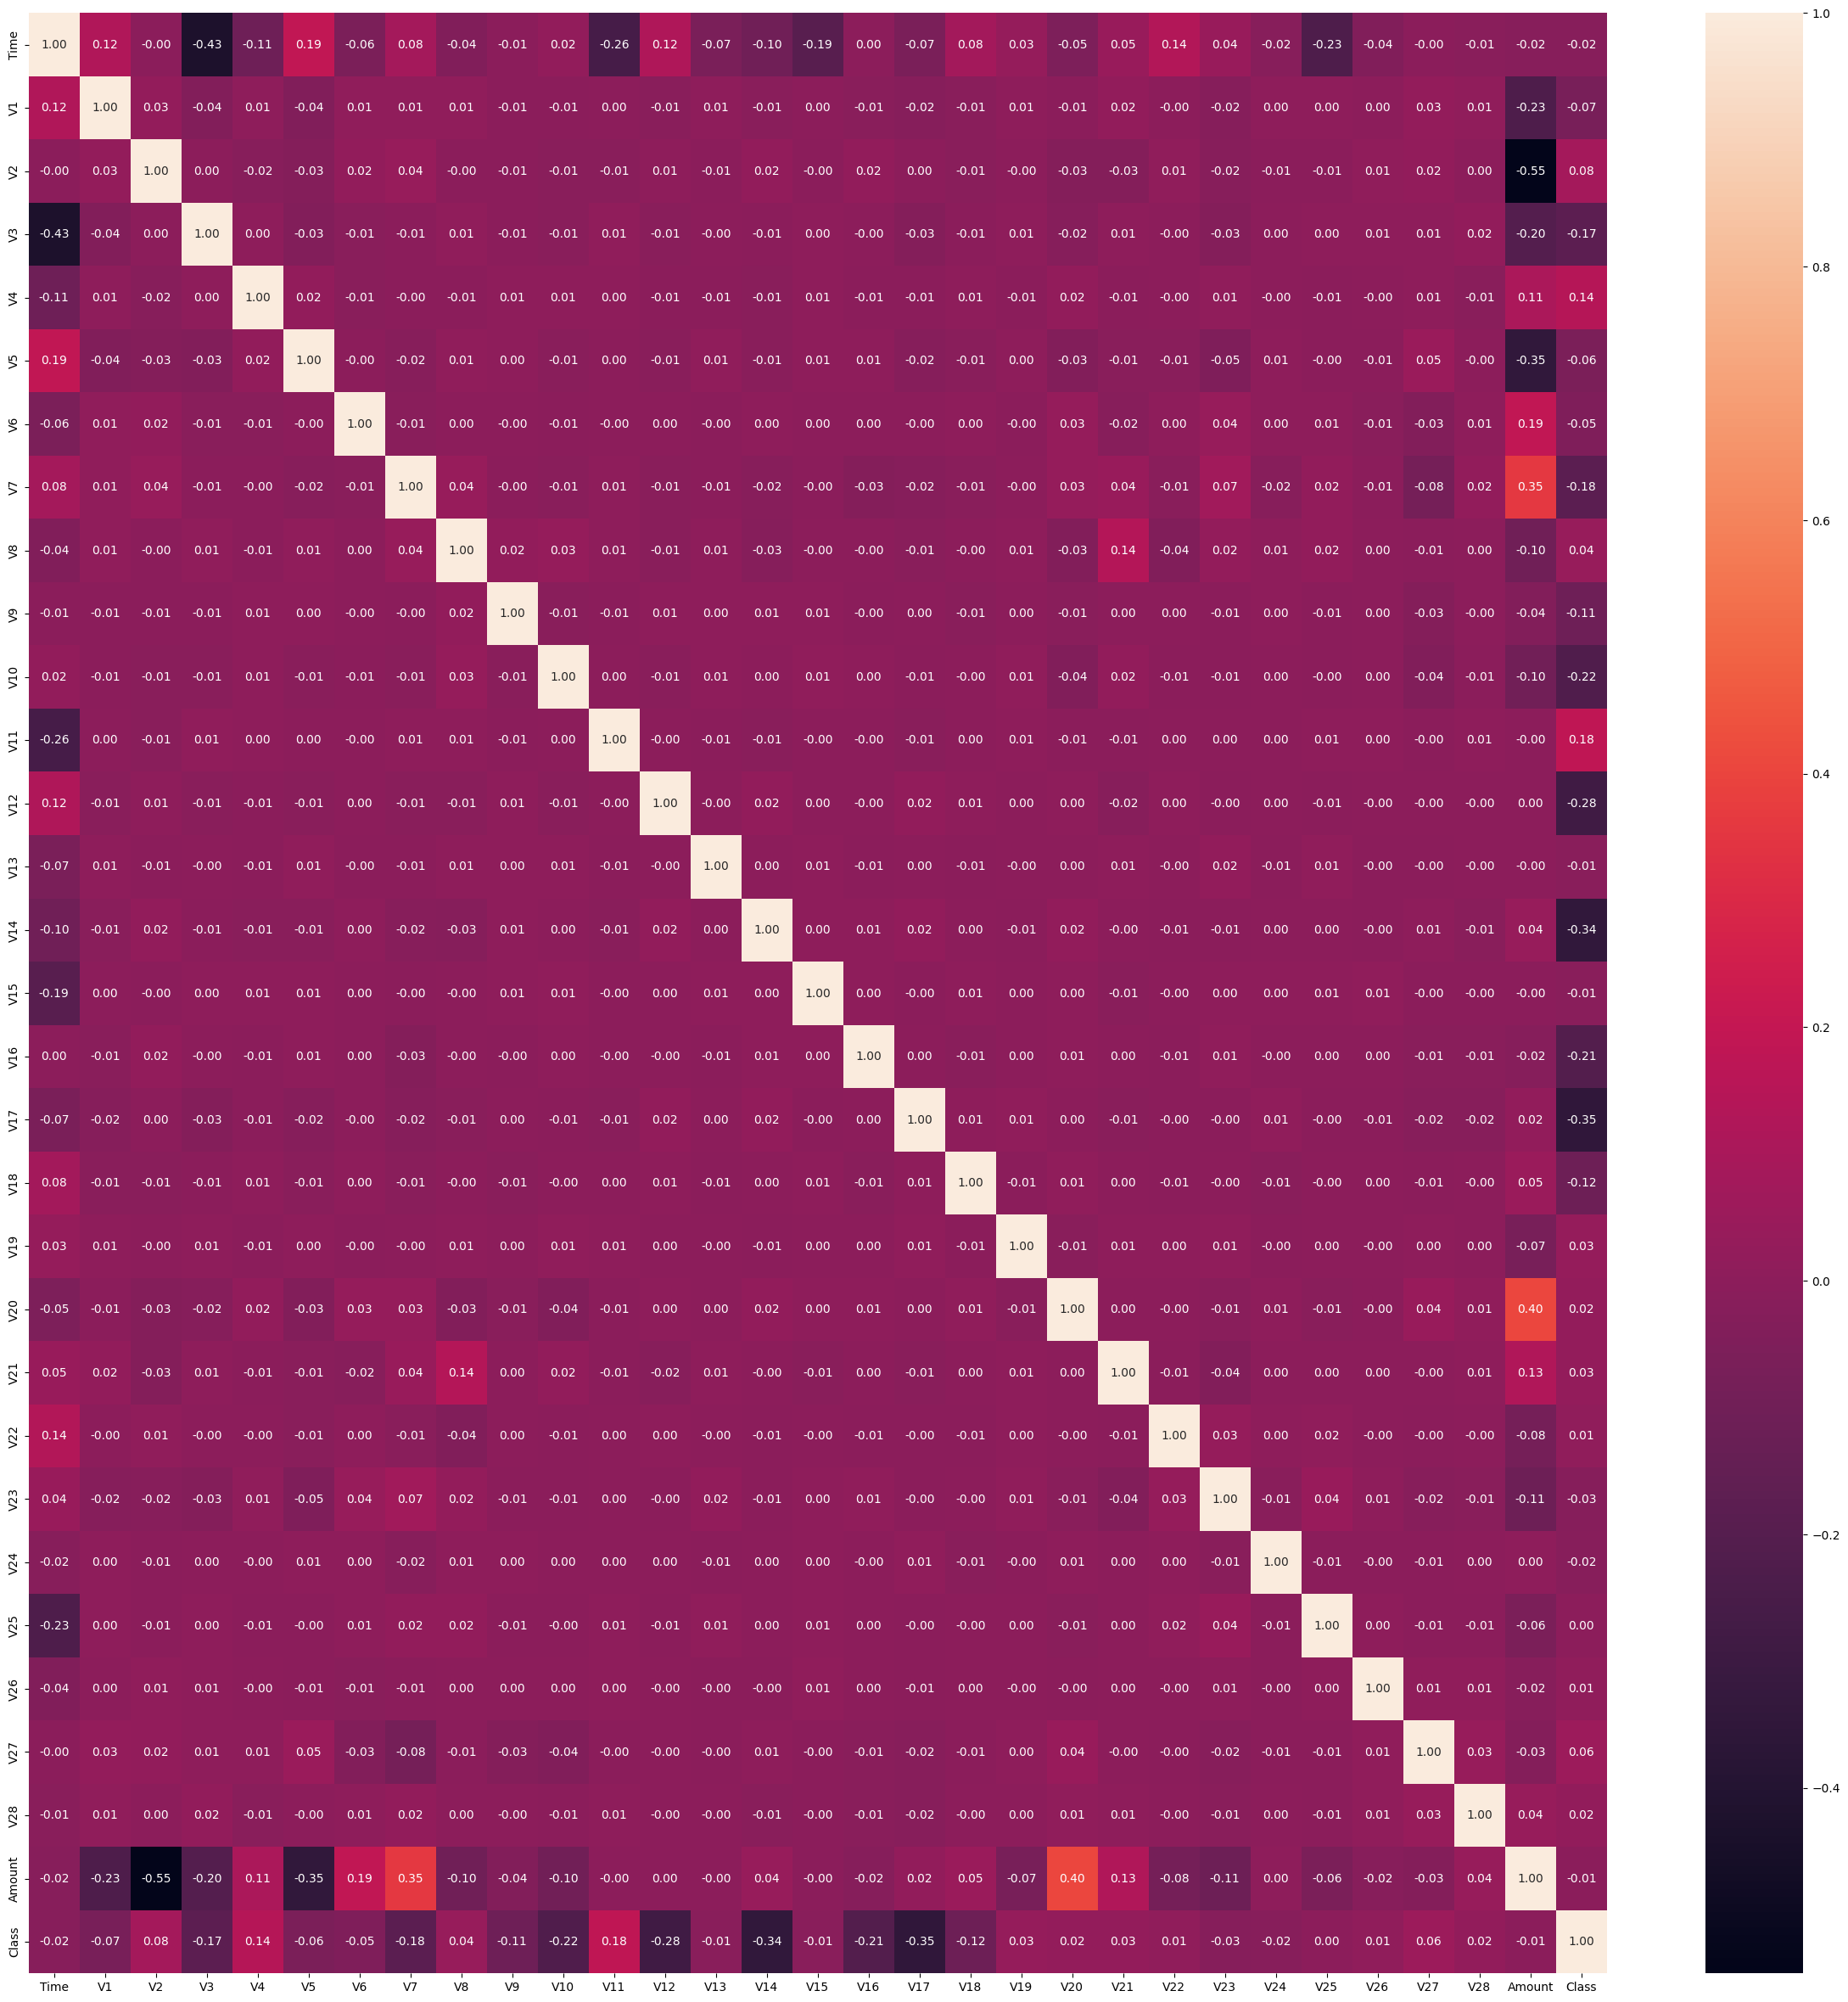

In [14]:
# get sample data
data1 = data.sample(frac=0.1)


# Find the correlation between the features 
plt.figure(figsize=(30,30))
sns.heatmap(data1.corr(), annot=True, fmt= '.2f')

# Here, we won't perform any data transformation as the data is already processed.

# Model Building

In [18]:
# Create Independent and Dependent Features 
X = data.drop("Class", axis=1)
y = data['Class']

In [21]:
Fraud = data[data.Class == 1]
Valid = data[data.Class == 0]
outlier_fraction = len(Fraud)/float(len(Valid))
outlier_fraction

0.0017304750013189597

In [33]:
# splitting the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

### Isolation Forest

In [29]:
model = IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=42, verbose=0)

In [34]:
model.fit(X_train)

d:\Created_by_me\Learning\INeuron\Internship Projects\Credit_card_fraud_detection\venv\lib\site-packages\sklearn\ensemble\_iforest.py:302: UserWarning: max_samples (284807) is greater than the total number of samples (199364). max_samples will be set to n_samples for estimation.
  warn(


IsolationForest(contamination=0.0017304750013189597, max_samples=284807,
                random_state=42)

In [38]:
y_train_pred = model.predict(X_train)

y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1

In [39]:
accuracy_score(y_train, y_train_pred)

0.9976826307658354

In [40]:
y_test_pred = model.predict(X_test)
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

In [41]:
accuracy_score(y_test, y_test_pred)

0.9975890359654974

In [25]:
# Define the outlier detection model 

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=42, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [43]:
for i, (model_name,model) in enumerate(classifiers.items()):
    if model_name == "Local Outlier Factor":
        y_pred = model.fit_predict(X)
    else:
        model.fit(X)
        y_pred = model.predict(X)

    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    accuracy = accuracy_score(y, y_pred)

    error_points =  (y_pred != y).sum()

    print("Model: ", model_name)
    print("Accuracy Score:", accuracy)

    print("Error Points:", error_points)

    print("Classification Report")
    print(classification_report(y, y_pred))
    


    # y_train_pred = model.predict(X_train)
    # y_train_pred[y_train_pred == 1] = 0
    # y_train_pred[y_train_pred == -1] = 1
    # train_accuracy = accuracy_score(y_train, y_train_pred)

    # y_test_pred = model.predict(X_test)
    # y_test_pred[y_test_pred == 1] = 0
    # y_test_pred[y_test_pred == -1] = 1
    # test_accuracy = accuracy_score(y_test, y_test_pred)

    # train_error_points =  (y_train_pred != y_train).sum()
    # test_error_points =  (y_test_pred != y_test).sum()

    # print("Accuracy Score for Train:", train_accuracy)
    # print("Accuracy Score for Test:", test_accuracy)

    # print('Error Points for ', model_name)
    # print("Error for Train:", train_error_points)
    # print("Error for Test:", test_error_points)

    # print("Classification Report")
    # print(classification_report(y_test, y_test_pred))
    print("\n===================================================\n")

    

Model:  Isolation Forest
Accuracy Score: 0.9976159293837581
Error Points: 679
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.31      0.31      0.31       492

    accuracy                           1.00    284807
   macro avg       0.65      0.65      0.65    284807
weighted avg       1.00      1.00      1.00    284807



Model:  Local Outlier Factor
Accuracy Score: 0.9967170750718908
Error Points: 935
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.05      0.05      0.05       492

    accuracy                           1.00    284807
   macro avg       0.52      0.52      0.52    284807
weighted avg       1.00      1.00      1.00    284807





In [ ]:
# n_outliers = len(Fraud)
# for i, (clf_name,clf) in enumerate(classifiers.items()):
#     #Fit the data and tag outliers
#     if clf_name == "Local Outlier Factor":
#         y_pred = clf.fit_predict(X)
#         scores_prediction = clf.negative_outlier_factor_
#     elif clf_name == "Support Vector Machine":
#         clf.fit(X)
#         y_pred = clf.predict(X)
#     else:    
#         clf.fit(X)
#         scores_prediction = clf.decision_function(X)
#         y_pred = clf.predict(X)
#     #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
#     y_pred[y_pred == 1] = 0
#     y_pred[y_pred == -1] = 1
#     n_errors = (y_pred != y).sum()
#     # Run Classification Metrics
#     print("{}: {}".format(clf_name,n_errors))
#     print("Accuracy Score :")
#     print(accuracy_score(y,y_pred))
#     print("Classification Report :")
#     print(classification_report(y,y_pred))

NameError: name 'Y' is not defined